In [38]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [40]:

import json
from itertools import islice
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

from pts.dataset import recipe as rcp

from pts.dataset.artificial import RecipeDataset
from pts.dataset import FileDataset, MetaData

from pts.dataset.repository import get_dataset
from pts.evaluation import make_evaluation_predictions, Evaluator
from pts.model.deepar import DeepAREstimator
from pts.model.simple_feedforward import SimpleFeedForwardEstimator
from pts.modules import (
    ImplicitQuantileOutput,
    PiecewiseLinearOutput,
)
from pts import Trainer



TIME_SERIE_LENGTH = 3 * 10 
PREDICTION_LENGTH = 3 
NUMBER_OF_TIME_SERIES = 2000

NUM_EPOCHS = 30
NUM_BATCHES_PER_EPOCH = 16
NUM_TRAININGS = 5
NUM_SAMPLES = 100
BATCH_SIZE = 64 * 2


        
def write_to_file(recipe, length, num_ts, file_name):
    with open("{}.json".format(file_name), 'w') as f:
        for x in islice(rcp.generate(length, recipe, "2019-01-07 00:00"), num_ts):
            z = {}
            for k in x:
                if type(x[k]) == np.ndarray:
                    z[k] = x[k].tolist()
                else:
                    z[k] = x[k]
            f.write(json.dumps(z))
            f.write('\n')

class RandomNegativeBinomial(rcp.Lifted):
    def __init__(self, n, p):
        self.n = n
        self.p = p
        
    def __call__(self, x, length, *args, **kwargs):
        return np.random.negative_binomial(self.n, self.p, length)
    

class RandomZeroInflatedNegativeBinomial(rcp.Lifted):
    def __init__(self, n, p, p_0):
        self.n = n
        self.p = p
        self.p_0 = p_0
        
    def __call__(self, x, length, *args, **kwargs):
        return np.random.binomial(1, self.p_0, length) * np.random.negative_binomial(self.n, self.p, length)
    
    
class RandomInflatedUniform(rcp.Lifted):
    def __init__(self, p_0, p_1):
        assert (p_0 + p_1 <= 1) and (p_0>=0) and (p_1>=0)
        self.p_0 = p_0
        self.p_1 = p_1
        self.p_uniform = 1 - p_0 - p_1
        
    def __call__(self, x, length, *args, **kwargs):
        result = np.zeros((length,))
        for i in range(length):
            c = np.random.choice([0, 1, 2], p=[self.p_0, self.p_1, self.p_uniform])
            if c == 1:
                result[i] = 1.
            elif c == 2: 
                result[i] = np.random.uniform()
        return result
            
class RandomGaussianMixture(rcp.Lifted):
    def __init__(
            self, mean, stddev, mixture_coef, shape=(0,)
    ) -> None:
        self.stddev = np.array(stddev).reshape(1, -1)
        self.mean = np.array(mean).reshape(1, -1)
        self.mixture_coef = mixture_coef
        self.shape = shape

    def __call__(self, x, length: int, *args, **kwargs):
        s = [length, self.stddev.shape[0]]
        choices = np.random.choice([0, 1, 2], p=self.mixture_coef, size=(length, ))
        all_samples = self.stddev * np.random.randn(*s) + self.mean
        result = np.zeros((length,))
        for i in range(length):
            c = choices[i]
            result[i] = all_samples[i, c]
        return result
        
        
def create_datasets(dataset_references):
    for fn in dataset_references:
        recipe = [("input", 1.), ("target", dataset_references[fn])]
        write_to_file(recipe, length=TIME_SERIE_LENGTH, num_ts=NUMBER_OF_TIME_SERIES, file_name=fn)



In [52]:
def run_one_training(dataset, distr_output, metadata):
#     estimator = SimpleFeedForwardEstimator(
#         distr_output=distr_output,
#         freq=metadata.freq,
#         prediction_length=metadata.prediction_length,
#         num_hidden_dimensions=[10],
# #         context_length=CONTEXT_LENGTH,
#         trainer=Trainer(device="cpu",
#                         epochs=NUM_EPOCHS,
#                         learning_rate=1e-3,
#                         num_batches_per_epoch=NUM_BATCHES_PER_EPOCH,
#                         batch_size=BATCH_SIZE,
#                         num_workers=1,
#                         ),
#     )

    estimator = DeepAREstimator(
        distr_output=distr_output,
        freq=metadata.freq,
        prediction_length=metadata.prediction_length,
        trainer=Trainer(device="cpu",
                        epochs=NUM_EPOCHS,
                        learning_rate=1e-3,
                        num_batches_per_epoch=NUM_BATCHES_PER_EPOCH,
                        batch_size=BATCH_SIZE,
#                         num_workers=1,
                        ),
        input_size=48,
    )
    predictor = estimator.train(dataset)
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,  # test dataset
        predictor=predictor,  # predictor
        num_samples=NUM_SAMPLES,  # number of sample paths we want for evaluation
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)
    evaluator = Evaluator()
    agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(dataset))
    
    all_quantiles_df = pd.DataFrame(
        [
            [forecasts[item_id].quantile(q/100.)[0] for q in range(0, 100)] 
            for item_id in range(len(forecasts))
        ]
    )
    sampled_quantiles = all_quantiles_df.mean(axis=0)
    return estimator, agg_metrics, sampled_quantiles


def run_several_training(dataset, distr_output, metadata, num_trainings=NUM_TRAININGS):
    estimators = []
    all_agg_metrics = []
    all_sampled_quantiles = []
    for i in range(num_trainings):
        estimator, agg_metrics, sampled_quantiles = run_one_training(dataset, distr_output, metadata)
        estimators.append(estimator)
        all_agg_metrics.append(agg_metrics)
        all_sampled_quantiles.append(sampled_quantiles)
        
    return estimators, all_agg_metrics, all_sampled_quantiles


def run_all_trainings(distr_outputs, dataset_references, metadata):
    store_results = {}
    for fn in dataset_references:
        dataset = FileDataset("{}.json".format(fn), metadata.freq, shuffle=True)
        for dn in distr_outputs:
            distr_output = distr_outputs[dn]
            estimators, all_agg_metrics, all_sampled_quantiles = run_several_training(dataset, distr_output, metadata)
            store_results[(fn, dn)] = {
                "estimators": estimators,
                "all_agg_metrics": all_agg_metrics, 
                "all_sampled_quantiles": all_sampled_quantiles,
            }
    return store_results






In [53]:
def plot_quantile_functions(all_sampled_quantiles):
    for serie in all_sampled_quantiles:
        plt.plot(serie)


def get_metrics(all_metrics, keys):
    agg_func = [np.mean, np.min, np.max]
    display(all_metrics[keys].agg(agg_func, axis=0).T)
    

def get_key_metrics(all_agg_metrics):
    KEY_METRICS = ["MASE", "sMAPE", "MSIS", "mean_wQuantileLoss", 
               "wQuantileLoss[0.1]", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
    all_metrics = pd.DataFrame(all_agg_metrics)
    get_metrics(all_metrics, KEY_METRICS)
    
def get_quantile_metrics(all_agg_metrics):
    all_metrics = pd.DataFrame(all_agg_metrics)
    QUANTILE_METRICS = [c for c in all_metrics.columns if ("Coverage" in c) or ("wQuantile" in c)]
    get_metrics(all_metrics, QUANTILE_METRICS)
       
    
def compare_trainings(store_results, dataset_reference=DATASET_REFERENCES):
    for fn in dataset_reference:
        true_distribution = dataset_reference[fn]
        random_values = rcp.evaluate([('target', true_distribution)], length=10000)['target']
        true_quantiles = [np.quantile(random_values, q=q/100) for q in range(0, 101)]
        
        for dn in distr_outputs:
            all_sampled_quantiles = store_results[(fn, dn)]["all_sampled_quantiles"]
            plt.plot(true_quantiles, color="black", linestyle='dashed',)
            plot_quantile_functions(all_sampled_quantiles)
            plt.legend(["True distribution"])
            plt.xlabel("Sampled quantile")
            plt.ylabel("Sampled value")
            plt.title("Distribution: {}, Estimator: {}".format(fn, dn))
            plt.show()

        for dn in distr_outputs:
            all_agg_metrics = store_results[(fn, dn)]["all_agg_metrics"]
            print("-------------------------------------------------")
            print("Distribution: {}, Estimator: {}".format(fn, dn))
            get_key_metrics(all_agg_metrics)
        
        for dn in distr_outputs:
            all_agg_metrics = store_results[(fn, dn)]["all_agg_metrics"]
            print("-------------------------------------------------")
            print("Distribution: {}, Estimator: {}".format(fn, dn))
            get_quantile_metrics(all_agg_metrics)


In [54]:
DATASET_REFERENCES = {
#     "uniform": rcp.RandomUniform(),
#     "gaussian(4, 10)": 4 + rcp.RandomGaussian(stddev=10),
#     "negative_binomial(10, 0.2)": RandomNegativeBinomial(10, 0.2),
    "negative_binomial(3, 0.2)": RandomNegativeBinomial(3, 0.2),
    "zero_inflated_negative_binomial(10, 0.2)": RandomZeroInflatedNegativeBinomial(10, 0.2, 0.6),
#     "random_int(0, 4)": rcp.RandomInteger(low=0., high=4.),
    "gaussian_mixture": RandomGaussianMixture(mean=[-3., 0, 3.], stddev=[0.4]*3, mixture_coef=[0.3, 0.4, 0.3], shape=(3,))
#     "inflated_uniform(0.5, 0.)": RandomInflatedUniform(0.5, 0.),
#     "inflated_uniform(0., 0.5)": RandomInflatedUniform(0., 0.5),
#     "inflated_uniform(0.25, 0.25)": RandomInflatedUniform(0.25, 0.25),
#     "inflated_uniform(0.30, 0.10)": RandomInflatedUniform(0.30, 0.10),
}    

META_DATA = MetaData(freq="H", prediction_length=PREDICTION_LENGTH)





In [56]:
dataset_references = {
    "negative_binomial(3, 0.2)": RandomNegativeBinomial(3, 0.2),
    "zero_inflated_negative_binomial(10, 0.2)": RandomZeroInflatedNegativeBinomial(10, 0.2, 0.6),
#     "gaussian_mixture": RandomGaussianMixture(mean=[-3., 0, 3.], stddev=[0.4]*3, mixture_coef=[0.3, 0.4, 0.3], shape=(3,))
}   


distr_outputs = {
    'iqn': ImplicitQuantileOutput(output_domain="Positive"),
    'piecewiseLinear_50': PiecewiseLinearOutput(num_pieces=50), 
}

create_datasets(dataset_references)
negative_binomial_results = run_all_trainings(distr_outputs, dataset_references, META_DATA)

15it [00:00, 18.62it/s, avg_epoch_loss=2.97, epoch=0]
15it [00:00, 16.44it/s, avg_epoch_loss=2.98, epoch=1]
15it [00:00, 20.47it/s, avg_epoch_loss=2.86, epoch=2]
15it [00:00, 19.67it/s, avg_epoch_loss=2.72, epoch=3]
15it [00:00, 19.59it/s, avg_epoch_loss=2.27, epoch=4]
15it [00:00, 19.72it/s, avg_epoch_loss=2.16, epoch=5]
15it [00:00, 20.14it/s, avg_epoch_loss=2.16, epoch=6]
15it [00:00, 19.78it/s, avg_epoch_loss=2.13, epoch=7]
15it [00:00, 19.25it/s, avg_epoch_loss=2.15, epoch=8]
15it [00:00, 18.08it/s, avg_epoch_loss=2.13, epoch=9]
15it [00:00, 20.30it/s, avg_epoch_loss=2.12, epoch=10]
15it [00:00, 19.85it/s, avg_epoch_loss=2.09, epoch=11]
15it [00:00, 20.08it/s, avg_epoch_loss=2.13, epoch=12]
15it [00:00, 19.69it/s, avg_epoch_loss=2.11, epoch=13]
15it [00:00, 20.46it/s, avg_epoch_loss=2.13, epoch=14]
15it [00:00, 18.95it/s, avg_epoch_loss=2.09, epoch=15]
15it [00:00, 16.34it/s, avg_epoch_loss=2.09, epoch=16]
15it [00:00, 18.13it/s, avg_epoch_loss=2.11, epoch=17]
15it [00:00, 18.40it

15it [00:00, 19.67it/s, avg_epoch_loss=2.06, epoch=24]
15it [00:00, 19.67it/s, avg_epoch_loss=2.05, epoch=25]
15it [00:00, 19.30it/s, avg_epoch_loss=2.03, epoch=26]
15it [00:00, 20.17it/s, avg_epoch_loss=2.08, epoch=27]
15it [00:00, 21.32it/s, avg_epoch_loss=2.04, epoch=28]
15it [00:00, 19.77it/s, avg_epoch_loss=2.02, epoch=29]
Running evaluation: 100%|██████████| 2000/2000 [00:00<00:00, 22080.11it/s]
15it [00:01, 14.21it/s, avg_epoch_loss=3.01, epoch=0]
15it [00:01, 13.76it/s, avg_epoch_loss=2.91, epoch=1]
15it [00:01, 13.15it/s, avg_epoch_loss=2.9, epoch=2]
15it [00:01, 14.67it/s, avg_epoch_loss=2.88, epoch=3]
15it [00:00, 15.08it/s, avg_epoch_loss=2.86, epoch=4]
15it [00:00, 15.86it/s, avg_epoch_loss=2.86, epoch=5]
15it [00:00, 15.64it/s, avg_epoch_loss=2.85, epoch=6]
15it [00:00, 15.91it/s, avg_epoch_loss=2.84, epoch=7]
15it [00:00, 15.74it/s, avg_epoch_loss=2.84, epoch=8]
15it [00:00, 15.04it/s, avg_epoch_loss=2.84, epoch=9]
15it [00:01, 13.69it/s, avg_epoch_loss=2.84, epoch=10]
1

15it [00:01, 14.09it/s, avg_epoch_loss=2.84, epoch=17]
15it [00:01, 12.47it/s, avg_epoch_loss=2.83, epoch=18]
15it [00:01, 14.21it/s, avg_epoch_loss=2.83, epoch=19]
15it [00:00, 15.17it/s, avg_epoch_loss=2.81, epoch=20]
15it [00:01, 12.77it/s, avg_epoch_loss=2.82, epoch=21]
15it [00:01, 13.16it/s, avg_epoch_loss=2.82, epoch=22]
15it [00:01, 13.55it/s, avg_epoch_loss=2.82, epoch=23]
15it [00:00, 15.60it/s, avg_epoch_loss=2.82, epoch=24]
15it [00:01, 14.79it/s, avg_epoch_loss=2.81, epoch=25]
15it [00:00, 15.25it/s, avg_epoch_loss=2.81, epoch=26]
15it [00:01, 14.96it/s, avg_epoch_loss=2.81, epoch=27]
15it [00:01, 14.82it/s, avg_epoch_loss=2.82, epoch=28]
15it [00:00, 15.29it/s, avg_epoch_loss=2.81, epoch=29]
Running evaluation: 100%|██████████| 2000/2000 [00:00<00:00, 29259.90it/s]
15it [00:00, 15.14it/s, avg_epoch_loss=7.71, epoch=0]
15it [00:00, 18.02it/s, avg_epoch_loss=6.84, epoch=1]
15it [00:00, 17.38it/s, avg_epoch_loss=6.67, epoch=2]
15it [00:01, 14.50it/s, avg_epoch_loss=6.64, epo

15it [00:00, 15.93it/s, avg_epoch_loss=6.18, epoch=10]
15it [00:00, 19.76it/s, avg_epoch_loss=6.31, epoch=11]
15it [00:00, 21.21it/s, avg_epoch_loss=6.18, epoch=12]
15it [00:00, 21.20it/s, avg_epoch_loss=6.15, epoch=13]
15it [00:00, 20.47it/s, avg_epoch_loss=6.22, epoch=14]
15it [00:00, 19.68it/s, avg_epoch_loss=6.17, epoch=15]
15it [00:00, 19.04it/s, avg_epoch_loss=6.13, epoch=16]
15it [00:00, 19.00it/s, avg_epoch_loss=6.24, epoch=17]
15it [00:00, 20.05it/s, avg_epoch_loss=6.18, epoch=18]
15it [00:00, 20.20it/s, avg_epoch_loss=6.18, epoch=19]
15it [00:00, 20.99it/s, avg_epoch_loss=6.16, epoch=20]
15it [00:00, 20.78it/s, avg_epoch_loss=6.16, epoch=21]
15it [00:00, 19.23it/s, avg_epoch_loss=6.22, epoch=22]
15it [00:00, 19.50it/s, avg_epoch_loss=6.19, epoch=23]
15it [00:00, 20.45it/s, avg_epoch_loss=6, epoch=24]   
15it [00:00, 17.74it/s, avg_epoch_loss=6.14, epoch=25]
15it [00:00, 18.80it/s, avg_epoch_loss=6.14, epoch=26]
15it [00:00, 19.35it/s, avg_epoch_loss=6.18, epoch=27]
15it [00:0

15it [00:01, 14.96it/s, avg_epoch_loss=3.9, epoch=3] 
15it [00:01,  7.51it/s, avg_epoch_loss=3.86, epoch=4]
15it [00:01, 13.05it/s, avg_epoch_loss=3.79, epoch=5]
15it [00:00, 15.73it/s, avg_epoch_loss=3.76, epoch=6]
15it [00:00, 15.69it/s, avg_epoch_loss=3.74, epoch=7]
15it [00:00, 15.47it/s, avg_epoch_loss=3.74, epoch=8]
15it [00:01, 14.64it/s, avg_epoch_loss=3.74, epoch=9]
15it [00:01, 15.00it/s, avg_epoch_loss=3.75, epoch=10]
15it [00:00, 15.55it/s, avg_epoch_loss=3.73, epoch=11]
15it [00:00, 15.40it/s, avg_epoch_loss=3.72, epoch=12]
15it [00:00, 15.57it/s, avg_epoch_loss=3.72, epoch=13]
15it [00:00, 15.32it/s, avg_epoch_loss=3.72, epoch=14]
15it [00:00, 15.54it/s, avg_epoch_loss=3.71, epoch=15]
15it [00:01, 11.99it/s, avg_epoch_loss=3.72, epoch=16]
15it [00:00, 15.26it/s, avg_epoch_loss=3.72, epoch=17]
15it [00:00, 15.05it/s, avg_epoch_loss=3.71, epoch=18]
15it [00:01, 14.86it/s, avg_epoch_loss=3.7, epoch=19]
15it [00:00, 15.62it/s, avg_epoch_loss=3.69, epoch=20]
15it [00:00, 16.06

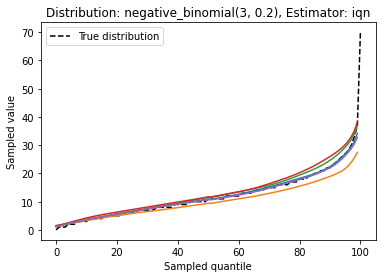

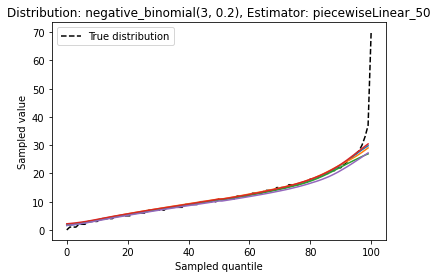

-------------------------------------------------
Distribution: negative_binomial(3, 0.2), Estimator: iqn


,mean,amin,amax
MASE,0.985517,0.970407,0.997410
sMAPE,0.540103,0.533271,0.555986
MSIS,6.418941,6.066205,7.321096
mean_wQuantileLoss,0.396785,0.389353,0.404545
wQuantileLoss[0.1],0.166522,0.165127,0.168692
wQuantileLoss[0.5],0.505548,0.497887,0.511279
wQuantileLoss[0.9],0.302450,0.288561,0.323127


-------------------------------------------------
Distribution: negative_binomial(3, 0.2), Estimator: piecewiseLinear_50


,mean,amin,amax
MASE,0.971158,0.969009,0.974601
sMAPE,0.533443,0.530971,0.535926
MSIS,6.212298,6.017413,6.508338
mean_wQuantileLoss,0.390154,0.388326,0.391656
wQuantileLoss[0.1],0.166814,0.166074,0.167171
wQuantileLoss[0.5],0.498135,0.497123,0.500671
wQuantileLoss[0.9],0.290074,0.286252,0.294960


-------------------------------------------------
Distribution: negative_binomial(3, 0.2), Estimator: iqn


,mean,amin,amax
Coverage[0.1],0.107267,0.082167,0.136333
Coverage[0.2],0.209100,0.165500,0.251500
Coverage[0.3],0.310633,0.236667,0.362333
Coverage[0.4],0.415300,0.312333,0.472667
Coverage[0.5],0.515367,0.404000,0.577333
Coverage[0.6],0.602367,0.491167,0.664000
Coverage[0.7],0.704267,0.591500,0.768500
Coverage[0.8],0.801433,0.685000,0.863833
Coverage[0.9],0.888767,0.796333,0.941167
wQuantileLoss[0.1],0.166522,0.165127,0.168692


-------------------------------------------------
Distribution: negative_binomial(3, 0.2), Estimator: piecewiseLinear_50


,mean,amin,amax
Coverage[0.1],0.100167,0.081167,0.115667
Coverage[0.2],0.206767,0.181833,0.228333
Coverage[0.3],0.307733,0.275333,0.332167
Coverage[0.4],0.410600,0.373667,0.434333
Coverage[0.5],0.511533,0.473667,0.537500
Coverage[0.6],0.596700,0.561000,0.619833
Coverage[0.7],0.688567,0.651500,0.711333
Coverage[0.8],0.787700,0.752667,0.810667
Coverage[0.9],0.892700,0.862833,0.907833
wQuantileLoss[0.1],0.166814,0.166074,0.167171


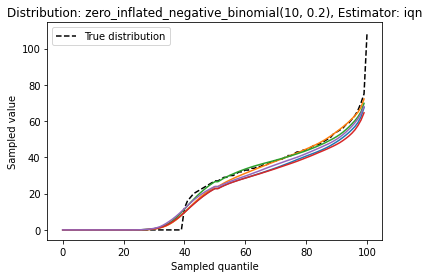

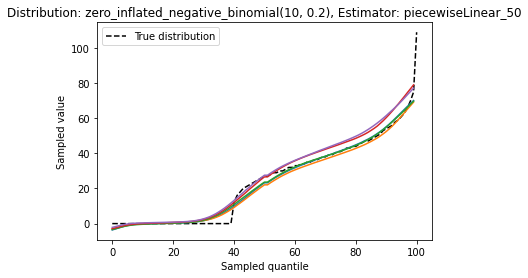

-------------------------------------------------
Distribution: zero_inflated_negative_binomial(10, 0.2), Estimator: iqn


,mean,amin,amax
MASE,1.282818,1.260469,1.308434
sMAPE,1.106930,1.069138,1.136448
MSIS,5.114161,4.943140,5.301816
mean_wQuantileLoss,0.586089,0.581961,0.588929
wQuantileLoss[0.1],0.200007,0.200001,0.200019
wQuantileLoss[0.5],0.848725,0.845360,0.853509
wQuantileLoss[0.9],0.347742,0.340776,0.356918


-------------------------------------------------
Distribution: zero_inflated_negative_binomial(10, 0.2), Estimator: piecewiseLinear_50


,mean,amin,amax
MASE,1.302050,1.286476,1.325037
sMAPE,1.098106,1.063682,1.135033
MSIS,5.202434,5.088824,5.447927
mean_wQuantileLoss,0.595286,0.587631,0.603418
wQuantileLoss[0.1],0.205419,0.202066,0.210110
wQuantileLoss[0.5],0.860035,0.852990,0.868099
wQuantileLoss[0.9],0.357025,0.345411,0.374602


-------------------------------------------------
Distribution: zero_inflated_negative_binomial(10, 0.2), Estimator: iqn


,mean,amin,amax
Coverage[0.1],0.404833,0.404833,0.404833
Coverage[0.2],0.404833,0.404833,0.404833
Coverage[0.3],0.405067,0.404833,0.405500
Coverage[0.4],0.421333,0.418000,0.426333
Coverage[0.5],0.499933,0.480833,0.525333
Coverage[0.6],0.585367,0.549833,0.631833
Coverage[0.7],0.678667,0.631833,0.732500
Coverage[0.8],0.772600,0.732500,0.821500
Coverage[0.9],0.871600,0.833500,0.921667
wQuantileLoss[0.1],0.200007,0.200001,0.200019


-------------------------------------------------
Distribution: zero_inflated_negative_binomial(10, 0.2), Estimator: piecewiseLinear_50


,mean,amin,amax
Coverage[0.1],0.208333,0.068000,0.384333
Coverage[0.2],0.383700,0.349000,0.404833
Coverage[0.3],0.404733,0.404167,0.405500
Coverage[0.4],0.421533,0.414167,0.433000
Coverage[0.5],0.521200,0.488000,0.554500
Coverage[0.6],0.642067,0.595667,0.693333
Coverage[0.7],0.746800,0.699333,0.793333
Coverage[0.8],0.835267,0.794833,0.874333
Coverage[0.9],0.929333,0.897167,0.954000
wQuantileLoss[0.1],0.205419,0.202066,0.210110


In [59]:
compare_trainings(negative_binomial_results, dataset_references)

In [60]:
gaussian_mixture_data_refs = {
    "gaussian_mixture": RandomGaussianMixture(mean=[-3., 0, 3.], stddev=[0.4]*3, mixture_coef=[0.3, 0.4, 0.3], shape=(3,))
}   


distr_outputs = {
    'iqn': ImplicitQuantileOutput(output_domain="Real"),
    'piecewiseLinear_50': PiecewiseLinearOutput(num_pieces=50), 
}

create_datasets(gaussian_mixture_data_refs)
gaussian_mixture_results = run_all_trainings(distr_outputs, gaussian_mixture_data_refs, META_DATA)

15it [00:00, 19.09it/s, avg_epoch_loss=1.06, epoch=0]
15it [00:00, 18.69it/s, avg_epoch_loss=0.972, epoch=1]
15it [00:00, 18.17it/s, avg_epoch_loss=0.966, epoch=2]
15it [00:00, 18.03it/s, avg_epoch_loss=0.957, epoch=3]
15it [00:00, 16.10it/s, avg_epoch_loss=0.938, epoch=4]
15it [00:00, 16.60it/s, avg_epoch_loss=0.864, epoch=5]
15it [00:00, 16.28it/s, avg_epoch_loss=0.759, epoch=6]
15it [00:00, 15.38it/s, avg_epoch_loss=0.716, epoch=7]
15it [00:00, 15.82it/s, avg_epoch_loss=0.706, epoch=8]
15it [00:00, 16.80it/s, avg_epoch_loss=0.695, epoch=9]
15it [00:00, 17.98it/s, avg_epoch_loss=0.698, epoch=10]
15it [00:00, 18.41it/s, avg_epoch_loss=0.683, epoch=11]
15it [00:00, 16.14it/s, avg_epoch_loss=0.684, epoch=12]
15it [00:00, 16.24it/s, avg_epoch_loss=0.691, epoch=13]
15it [00:00, 16.89it/s, avg_epoch_loss=0.68, epoch=14] 
15it [00:00, 19.74it/s, avg_epoch_loss=0.685, epoch=15]
15it [00:00, 20.04it/s, avg_epoch_loss=0.676, epoch=16]
15it [00:00, 18.24it/s, avg_epoch_loss=0.689, epoch=17]
15i

15it [00:00, 20.36it/s, avg_epoch_loss=0.659, epoch=21]
15it [00:00, 20.66it/s, avg_epoch_loss=0.668, epoch=22]
15it [00:00, 20.72it/s, avg_epoch_loss=0.671, epoch=23]
15it [00:00, 20.63it/s, avg_epoch_loss=0.672, epoch=24]
15it [00:00, 20.28it/s, avg_epoch_loss=0.664, epoch=25]
15it [00:00, 20.42it/s, avg_epoch_loss=0.667, epoch=26]
15it [00:00, 20.41it/s, avg_epoch_loss=0.678, epoch=27]
15it [00:00, 19.29it/s, avg_epoch_loss=0.678, epoch=28]
15it [00:00, 19.36it/s, avg_epoch_loss=0.673, epoch=29]
Running evaluation: 100%|██████████| 2000/2000 [00:00<00:00, 24654.61it/s]
15it [00:00, 15.42it/s, avg_epoch_loss=5.64, epoch=0]
15it [00:00, 15.30it/s, avg_epoch_loss=1.97, epoch=1]
15it [00:00, 15.62it/s, avg_epoch_loss=1.64, epoch=2]
15it [00:00, 15.64it/s, avg_epoch_loss=1.63, epoch=3]
15it [00:00, 15.25it/s, avg_epoch_loss=5.93, epoch=4]
15it [00:01, 14.98it/s, avg_epoch_loss=1.8, epoch=5] 
15it [00:01, 14.95it/s, avg_epoch_loss=2.29, epoch=6]
15it [00:00, 15.55it/s, avg_epoch_loss=1.61

15it [00:01, 14.77it/s, avg_epoch_loss=1.46, epoch=13]
15it [00:00, 15.01it/s, avg_epoch_loss=1.52, epoch=14]
15it [00:01, 14.99it/s, avg_epoch_loss=1.92, epoch=15]
15it [00:00, 15.12it/s, avg_epoch_loss=1.49, epoch=16]
15it [00:00, 15.11it/s, avg_epoch_loss=1.57, epoch=17]
15it [00:01, 13.94it/s, avg_epoch_loss=1.47, epoch=18]
15it [00:00, 15.13it/s, avg_epoch_loss=1.47, epoch=19]
15it [00:00, 15.30it/s, avg_epoch_loss=1.61, epoch=20]
15it [00:00, 15.51it/s, avg_epoch_loss=1.55, epoch=21]
15it [00:00, 15.04it/s, avg_epoch_loss=1.7, epoch=22] 
15it [00:01, 13.39it/s, avg_epoch_loss=1.49, epoch=23]
15it [00:00, 15.16it/s, avg_epoch_loss=1.55, epoch=24]
15it [00:00, 15.37it/s, avg_epoch_loss=1.57, epoch=25]
15it [00:00, 15.38it/s, avg_epoch_loss=5.55, epoch=26]
15it [00:00, 15.06it/s, avg_epoch_loss=2.12, epoch=27]
15it [00:00, 15.37it/s, avg_epoch_loss=1.61, epoch=28]
15it [00:00, 15.33it/s, avg_epoch_loss=1.55, epoch=29]
Running evaluation: 100%|██████████| 2000/2000 [00:00<00:00, 1960

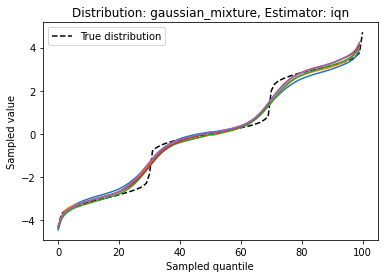

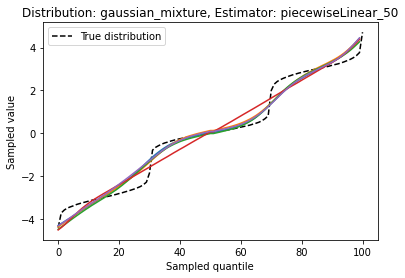

-------------------------------------------------
Distribution: gaussian_mixture, Estimator: iqn


,mean,amin,amax
MASE,1.019615,1.018011,1.020691
sMAPE,1.752594,1.730160,1.769880
MSIS,4.150269,4.101221,4.208563
mean_wQuantileLoss,0.772312,0.770979,0.773878
wQuantileLoss[0.1],0.363622,0.361421,0.368376
wQuantileLoss[0.5],1.005505,1.003678,1.006539
wQuantileLoss[0.9],0.360761,0.357125,0.366611


-------------------------------------------------
Distribution: gaussian_mixture, Estimator: piecewiseLinear_50


,mean,amin,amax
MASE,1.024113,1.018549,1.041364
sMAPE,1.733953,1.660741,1.764354
MSIS,4.587857,4.517185,4.664442
mean_wQuantileLoss,0.783852,0.780163,0.789038
wQuantileLoss[0.1],0.387864,0.386863,0.389850
wQuantileLoss[0.5],1.010814,1.005348,1.026673
wQuantileLoss[0.9],0.379166,0.373581,0.382197


-------------------------------------------------
Distribution: gaussian_mixture, Estimator: iqn


,mean,amin,amax
Coverage[0.1],0.117667,0.091500,0.146167
Coverage[0.2],0.219533,0.197333,0.246167
Coverage[0.3],0.304800,0.293333,0.315333
Coverage[0.4],0.394467,0.368500,0.429833
Coverage[0.5],0.500100,0.471000,0.528667
Coverage[0.6],0.597033,0.584333,0.606833
Coverage[0.7],0.692933,0.688167,0.699667
Coverage[0.8],0.787533,0.751167,0.811333
Coverage[0.9],0.893467,0.847000,0.926167
wQuantileLoss[0.1],0.363622,0.361421,0.368376


-------------------------------------------------
Distribution: gaussian_mixture, Estimator: piecewiseLinear_50


,mean,amin,amax
Coverage[0.1],0.086067,0.064000,0.105333
Coverage[0.2],0.238900,0.226500,0.249167
Coverage[0.3],0.306100,0.299333,0.309833
Coverage[0.4],0.387867,0.335833,0.419167
Coverage[0.5],0.514733,0.487333,0.539833
Coverage[0.6],0.619433,0.587333,0.660667
Coverage[0.7],0.690967,0.687833,0.696833
Coverage[0.8],0.770933,0.749333,0.785167
Coverage[0.9],0.907667,0.898500,0.915333
wQuantileLoss[0.1],0.387864,0.386863,0.389850


In [61]:
compare_trainings(gaussian_mixture_results, gaussian_mixture_data_refs)